## Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping the data folder

In [2]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/smai_a4/fashion_mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

!rm -rf /content/__MACOSX

## Solving Fragmentation issue for memory

In [3]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Imports

In [4]:
import struct
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn

## Function to read dataset

In [5]:
def read_idx3_ubyte(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and dimensions of the dataset
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))

        # Read the rest of the data
        images = np.frombuffer(f.read(), dtype=np.uint8)

        # Reshape to [num_images, rows, cols]
        images = images.reshape(num_images, rows, cols)

    return images

def read_idx1_ubyte(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and number of items
        magic, num_items = struct.unpack('>II', f.read(8))

        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return labels

## Optimal Number of dimenstions

In [6]:
op_dim = 7

## Dataloader

In [7]:
class MultiMNISTDataset:
    def __init__(self, data, labels, batch_size=32, shuffle=True, task="classification"):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))  # Track the indexes for shuffling
        self.current_index = 0
        self.task = task

        if self.shuffle:
            self._shuffle_data()

    def _shuffle_data(self):
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            self._shuffle_data()
        return self

    def __next__(self):
        if self.current_index >= len(self.data):
            raise StopIteration

        # Compute the indices of the current batch
        start_idx = self.current_index
        end_idx = min(start_idx + self.batch_size, len(self.data))

        # Fetch the batch data and labels
        batch_indexes = self.indexes[start_idx:end_idx]
        batch_data = self.data[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Update the current index
        self.current_index = end_idx

        # Convert NumPy arrays to PyTorch tensors
        batch_data_tensor = torch.from_numpy(batch_data).float().unsqueeze(1)
        if self.task == "classification":
            batch_labels_tensor = torch.from_numpy(batch_labels).long()
        elif self.task == "regression":
            batch_labels_tensor = torch.from_numpy(batch_labels).float()

        return batch_data_tensor, batch_labels_tensor

## Performance Metrics Class

In [8]:
class PerformanceMetrics:
    def MSE(self, y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_error = y_true - y_pred
        mse = np.mean(y_error ** 2)
        return mse

    def variance(self, arr):
        arr = np.array(arr)
        mean = np.mean(arr)
        var = np.mean((arr - mean) ** 2)
        return var

    def standard_deviation(self, arr):
        var = self.variance(arr)
        return np.sqrt(var)

    def accuracy(self, y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        n_correct = 0
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                n_correct += 1
        total = len(y_true)
        return n_correct / total

    def get_precision_recall_f1_onehot_single_class(self, y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        n_classes = y_true.shape[1]
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        list_of_confusion_matrices = []
        for cls in range(n_classes):
            confusion_matrix = self.confusion_matrix(cls, y_true, y_pred)
            list_of_confusion_matrices.append(confusion_matrix)
        list_of_precisions = self.precision(list_of_confusion_matrices)
        list_of_recalls = self.recall(list_of_confusion_matrices)
        list_of_f1_scores = self.f1_score(list_of_precisions, list_of_recalls)
        return list_of_precisions, list_of_recalls, list_of_f1_scores

    def get_precision_recall_f1_onehot_multi_class(self, y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        y_pred = np.where(y_pred > 0.5, 1, 0)

        n_classes = y_pred.shape[1]
        list_of_confusion_matrices = [np.zeros((2, 2)) for _ in range(n_classes)]
        for cls in range(n_classes):
            y_true_cls = y_true[:, cls]
            y_pred_cls = y_pred[:, cls]
            for i in range(len(y_true_cls)):
                if y_true_cls[i] == 1:
                    if y_pred_cls[i] == 1:
                        list_of_confusion_matrices[cls][0][0] += 1
                    else:
                        list_of_confusion_matrices[cls][0][1] += 1
                else:
                    if y_pred_cls[i] == 1:
                        list_of_confusion_matrices[cls][1][0] += 1
                    else:
                        list_of_confusion_matrices[cls][1][1] += 1
        list_of_precisions = self.precision(list_of_confusion_matrices)
        list_of_recalls = self.recall(list_of_confusion_matrices)
        list_of_f1_scores = self.f1_score(list_of_precisions, list_of_recalls)
        return list_of_precisions, list_of_recalls, list_of_f1_scores

    # Does not return matrix values in percentages - as usual confusion matrix has, but returns the counts
    def confusion_matrix(self, cls, y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        cls_confusion_matrix = np.zeros((2, 2))

        for i in range(len(y_true)):
            if y_true[i] == cls:
                if y_pred[i] == cls:
                    cls_confusion_matrix[0][0] += 1
                else:
                    cls_confusion_matrix[0][1] += 1
            else:
                if y_pred[i] == cls:
                    cls_confusion_matrix[1][0] += 1
                else:
                    cls_confusion_matrix[1][1] += 1
        return cls_confusion_matrix

    def precision(self, list_of_confusion_matrices):
        list_of_micro_precisions = []
        for confusion_matrix in list_of_confusion_matrices:
            tp = confusion_matrix[0][0]
            fp = confusion_matrix[0][1]
            micro_precision = tp / (tp + fp + 1e-10) # 1e-10 is added to avoid division by zero
            list_of_micro_precisions.append(micro_precision)
        return list_of_micro_precisions

    def recall(self, list_of_confusion_matrices):
        list_of_micro_recalls = []
        for confusion_matrix in list_of_confusion_matrices:
            tp = confusion_matrix[0][0]
            fn = confusion_matrix[1][0]
            micro_recall = tp / (tp + fn + 1e-10) # 1e-10 is added to avoid division by zero
            list_of_micro_recalls.append(micro_recall)
        return list_of_micro_recalls

    def f1_score(self, list_of_precisions, list_of_recall):
        list_of_f1_scores = []
        for i in range(len(list_of_precisions)):
            precision = list_of_precisions[i]
            recall = list_of_recall[i]
            f1 = (2 * precision * recall) / (precision + recall + 1e-10) # 1e-10 is added to avoid division by zero
            list_of_f1_scores.append(f1)
        return list_of_f1_scores

    def cross_entropy(self, y_true, y_hat):
        y_true = np.array(y_true)
        y_hat = np.array(y_hat)
        cross_entropy = -np.mean(y_true * np.log(y_hat + 1e-10))
        return cross_entropy

    def RMSE(self, y_true, y_hat):
        mse = self.MSE(y_true, y_hat)
        return np.sqrt(mse)

    def MAE(self, y_true, y_hat):
        y_true = np.array(y_true)
        y_hat = np.array(y_hat)
        mae = np.mean(np.abs(y_true - y_hat))
        return mae

    def R2(self, y_true, y_hat):
        y_true = np.array(y_true)
        y_hat = np.array(y_hat)
        mean = np.mean(y_true)
        ss_total = np.sum((y_true - mean) ** 2)
        ss_res = np.sum((y_true - y_hat) ** 2)
        r2 = 1 - (ss_res / (ss_total + 1e-10))
        return r2

    def hamming_loss(self, y_true, y_hat):
        y_true = np.array(y_true)
        y_hat = np.array(y_hat)
        differences = np.not_equal(y_true, y_hat)
        total_loss = np.sum(differences)
        hamming_loss = total_loss / y_true.shape[0]
        return hamming_loss

## KNN Model

In [9]:
class KNN(PerformanceMetrics):
    def __init__(self, k, dist_metric):
        self.k = k
        self.dist_metric = dist_metric # manhattan, euclidean, cosine
        self.train_data = None
        self.validation_data = None
        self.test_data = None
        self.to_predict = None  # Column name to predict
        self.features = None    # Features to use for prediction
        self.cols = None        # Column names
        self.true_vals = None   # True values of the variable to predict
        self.predicted_vals = None  # Predicted values of the variable to predict

    # Getter and Setter for variable to predict
    def set_predict_var(self, column_name):
        self.to_predict = column_name

    def get_predict_var(self):
        return self.to_predict

    # Set the features to use for making predictions
    def use_for_prediction(self, features):
        self.features = features

    # Returns the list of features used for making predictions
    def get_features_used_for_prediction(self):
        return self.features

    # Getter and Setter for k
    def get_k(self):
        return self.k

    def set_k(self, new_k):
        self.k = new_k

    # Getter and setter for distance metric
    def get_dist_metric(self):
        return self.dist_metric

    def set_dist_metric(self, new_dist_metric):
        self.dist_metric = new_dist_metric

    # Load the training, testing and validation data
    def load_train_test_val_data(self, headers, train_data, test_data, validation_data):
        self.cols = headers
        self.train_data = train_data
        self.test_data = test_data
        self.validation_data = validation_data

    # Calculate the distance between a single data point and an array of data points
    def calc_distance(self, x1, x2_arr):
        if self.dist_metric == "manhattan":
            return np.sum(np.abs(x2_arr - x1), axis=1)
        elif self.dist_metric == "euclidean":
            return np.linalg.norm(x2_arr - x1, axis=1)
        elif self.dist_metric == "cosine":
            vector_norm = np.linalg.norm(x1)
            vectors_array_norm = np.linalg.norm(x2_arr, axis=1)
            dot_products = np.dot(x2_arr, x1)
            return dot_products / (vector_norm * vectors_array_norm)
        else:
            raise ValueError("Invalid distance metric")

    # Fit the model
    def fit(self):
        pass

    # Assumes the order and number of columns (except the label column) in test data is the same as in train data
    def predict(self, type_of_data):
        features_to_use_idx = [self.cols.index(feature) for feature in self.features]
        filtered_train_data = self.train_data[:, features_to_use_idx]
        filtered_to_predict_data = None
        train_data_labels = self.train_data[:, -1]

        if type_of_data == "test":
            # Refining testing data points
            filtered_to_predict_data = self.test_data[:, features_to_use_idx]
            self.true_vals = self.test_data[:, -1]
        elif type_of_data == "validation":
            # Refining validation data points
            filtered_to_predict_data = self.validation_data[:, features_to_use_idx]
            self.true_vals = self.validation_data[:, -1]

        # Converting them to float32 for optimisation
        filtered_train_data = np.float32(filtered_train_data)
        filtered_to_predict_data = np.float32(filtered_to_predict_data)

        predictions = []
        for data_point in filtered_to_predict_data:
            distances = self.calc_distance(data_point, filtered_train_data)

            distance_label_pairs = list(zip(distances, train_data_labels))
            sorted_pairs = sorted(distance_label_pairs, key=lambda x: x[0])
            top_k_labels = [label for _, label in sorted_pairs[:self.k]]

            '''
                The below line of code is given by ChatGPT
                Prompt: given a list of labels find the most common label in the list in 1 line of code
            '''
            # =============================================================================
            most_frequent_label = max(set(top_k_labels), key=top_k_labels.count)
            # =============================================================================
            predictions.append(most_frequent_label)

        self.predicted_vals = np.array(predictions)
        return predictions

    def get_metrics(self):
        if self.predicted_vals is None or self.true_vals is None:
            raise ValueError("Predictions have not been made yet - run the model atleast once before getting metrics")

        list_of_classes = list(set(self.true_vals))

        # Calculate the confusion matrix for each of the classes
        list_of_confusion_matrices = []

        for cls in list_of_classes:
            list_of_confusion_matrices.append(self.confusion_matrix(cls, self.true_vals, self.predicted_vals))

        # Pool the confusion matrices: Summing the matrices cell wise
        pooled_confusion_matrix = np.sum(list_of_confusion_matrices, axis=0)

        # Calculate the accuracy of the model
        accuracy = self.accuracy(self.true_vals, self.predicted_vals)

        list_of_individual_precisions = self.precision(list_of_confusion_matrices)
        list_of_individual_recalls = self.recall(list_of_confusion_matrices)
        list_of_individual_f1_scores = self.f1_score(list_of_individual_precisions, list_of_individual_recalls)

        macro_precision = np.mean(np.array(list_of_individual_precisions))
        macro_recall = np.mean(np.array(list_of_individual_recalls))
        macro_f1_score = np.mean(np.array(list_of_individual_f1_scores))

        micro_precision = self.precision([pooled_confusion_matrix])[0]
        micro_recall = self.recall([pooled_confusion_matrix])[0]
        micro_f1_score = self.f1_score([micro_precision], [micro_recall])[0]

        return {
            "accuracy": accuracy,
            "macro_precision": macro_precision,
            "macro_recall": macro_recall,
            "macro_f1_score": macro_f1_score,
            "micro_precision": micro_precision,
            "micro_recall": micro_recall,
            "micro_f1_score": micro_f1_score
        }

## CNN Autoencoder

In [40]:
class CNN_Autoencoder(nn.Module):
    # Set the best model number here as the model to use (Model 2 was found to work the best)
    def __init__(self, act_func: str, lr: float, dropout: float, optimiser: str, model_num: int = 2):
        super(CNN_Autoencoder, self).__init__()
        self.loss = nn.MSELoss()

        if act_func == 'relu':
            self.activation = torch.relu
        elif act_func == 'sigmoid':
            self.activation = torch.sigmoid
        elif act_func == 'tanh':
            self.activation = torch.tanh
        else:
            raise ValueError('Activation function not supported.')

        self.lr = lr
        self.dropout = dropout
        self.op = optimiser
        self.model_num = model_num

        if self.model_num==1 or self.model_num==2 or self.model_num==3:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 16, 3)                            # 1x28x28 -> 16x26x26
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 16x26x26 -> 16x13x13
            self.conv2 = nn.Conv2d(16, 32, 3)                           # 16x13x13 -> 32x11x11
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)     # 32x11x11 -> 32x5x5
            self.conv3 = nn.Conv2d(32, 64, 5)                           # 32x5x5 -> 64x1x1

            # Decoder layers
            self.inv_conv3 = nn.ConvTranspose2d(64, 32, 5)              # 64x1x1 -> 32x5x5
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)                      # 32x5x5 -> 32x11x11
            self.inv_conv2 = nn.ConvTranspose2d(32, 16, 3)              # 32x11x11 -> 16x13x13
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 16x13x13 -> 16x26x26
            self.inv_conv1 = nn.ConvTranspose2d(16, 1, 3)               # 16x26x26 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        elif self.model_num == 2:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 32, 5)                            # 1x28x28 -> 32x24x24
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 32x24x24 -> 32x12x12
            self.conv2 = nn.Conv2d(32, 64, 5)                           # 64x12x12 -> 64x8x8
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)     # 64x8x8 -> 64x4x4
            self.conv3 = nn.Conv2d(64, 9, 4)                          # 64x4x4 -> 128x1x1

            # Decoder layers
            self.inv_conv3 = nn.ConvTranspose2d(9, 64, 4)             # 128x1x1 -> 64x4x4
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)                      # 64x4x4 -> 64x8x8
            self.inv_conv2 = nn.ConvTranspose2d(64, 32, 5)              # 64x8x8 -> 32x12x12
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 32x12x12 -> 32x24x24
            self.inv_conv1 = nn.ConvTranspose2d(32, 1, 5)               # 32x24x24 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        elif self.model_num == 3:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 64, 5)                            # 1x28x28 -> 64x24x24
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 64x24x24 -> 64x12x12
            self.conv2 = nn.Conv2d(64, 128, 5)                          # 64x12x12 -> 128x8x8
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)     # 128x8x8 -> 128x4x4
            self.conv3 = nn.Conv2d(128, 256, 4)                         # 128x4x4 -> 256x1x1

            # Decoder layers
            self.inv_conv3 = nn.ConvTranspose2d(256, 128, 4)            # 256x1x1 -> 128x4x4
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)                      # 128x4x4 -> 128x8x8
            self.inv_conv2 = nn.ConvTranspose2d(128, 64, 5)             # 128x8x8 -> 64x12x12
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 64x12x12 -> 64x24x24
            self.inv_conv1 = nn.ConvTranspose2d(64, 1, 5)               # 64x24x24 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        # Keeping the latent space dimensions same and varying the depth of the model
        elif self.model_num == 4:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 128, 5)                            # 1x28x28 -> 64x24x24
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 64x24x24 -> 64x12x12
            self.conv2 = nn.Conv2d(128, 256, 12)                         # 64x12x12 -> 128x1x1

            # Decoder layers
            self.inv_conv2 = nn.ConvTranspose2d(256, 128, 12)            # 128x1x1 -> 64x12x12
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)                      # 64x12x12 -> 64x24x24
            self.inv_conv1 = nn.ConvTranspose2d(128, 1, 5)               # 64x24x24 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        elif self.model_num == 5:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 512, 5)                            # 1x28x28 -> 64x24x24
            self.conv2 = nn.Conv2d(512, 256, 5)                          # 64x24x24 -> 128x20x20
            self.conv3 = nn.Conv2d(256, 128, 20)

            # Decoder layers
            self.inv_conv3 = nn.ConvTranspose2d(128, 256, 20)
            self.inv_conv2 = nn.ConvTranspose2d(256, 512, 5)             # 128x1x1 -> 64x24x24
            self.inv_conv1 = nn.ConvTranspose2d(512, 1, 5)               # 64x24x24 -> 1x28x28
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

        elif self.model_num == 6:
            # Encoding layers
            self.conv1 = nn.Conv2d(1, 1024, 3)                          # 1x28x28 -> 1024x26x26
            self.maxpool1 = nn.MaxPool2d(2, 2, return_indices=True)     # 1024x26x26 -> 1024x13x13
            self.conv2 = nn.Conv2d(1024, 512, 3)                        # 1024x13x13 -> 512x11x11
            self.maxpool2 = nn.MaxPool2d(2, 2, return_indices=True)     # 512x11x11 -> 512x5x5
            self.conv3 = nn.Conv2d(512, 256, 3)                         # 512x5x5 -> 386x3x3
            self.conv4 = nn.Conv2d(256, 128, 3)                         # 386x3x3 -> 256x1x1

            # Decoding layers
            self.inv_conv4 = nn.ConvTranspose2d(128, 256, 3)
            self.inv_conv3 = nn.ConvTranspose2d(256, 512, 3)
            self.maxunpool2 = nn.MaxUnpool2d(2, 2)
            self.inv_conv2 = nn.ConvTranspose2d(512, 1024, 3)
            self.maxunpool1 = nn.MaxUnpool2d(2, 2)
            self.inv_conv1 = nn.ConvTranspose2d(1024, 1, 3)
            self.normalise = nn.Sigmoid()                               # Normalise the output image in range [0, 1]

    def encoder(self, x):
        if self.model_num==1 or self.model_num==2 or self.model_num==3:
            # Initialising values to None
            indices1 = indices2 = input_shape1 = input_shape2 = None

            x = self.activation(self.conv1(x))
            input_shape1 = x.shape
            x, indices1 = self.maxpool1(x)
            x = self.activation(self.conv2(x))
            input_shape2 = x.shape
            x, indices2 = self.maxpool2(x)
            x = self.activation(self.conv3(x))
            return x, indices1, indices2, input_shape1, input_shape2

        elif self.model_num==4:
            indices1 = input_shape1 = None
            x = self.activation(self.conv1(x))
            input_shape1 = x.shape
            x, indices1 = self.maxpool1(x)
            x = self.activation(self.conv2(x))
            return x, indices1, input_shape1

        elif self.model_num==5:
            x = self.activation(self.conv1(x))
            x = self.activation(self.conv2(x))
            x = self.activation(self.conv3(x))
            return x

        elif self.model_num==6:
            indices1 = indices2 = input_shape1 = input_shape2 = 0
            x = self.activation(self.conv1(x))
            input_shape1 = x.shape
            x, indices1 = self.maxpool1(x)
            x = self.activation(self.conv2(x))
            input_shape2 = x.shape
            x, indices2 = self.maxpool2(x)
            x = self.activation(self.conv3(x))
            x = self.activation(self.conv4(x))
            return x, indices1, indices2, input_shape1, input_shape2

    def decoder(self, x, indices1=None, indices2=None, input_shape1=None, input_shape2=None):
        if self.model_num==1 or self.model_num==2 or self.model_num==3:
            x = self.activation(self.inv_conv3(x))
            x = self.maxunpool2(x, indices2, output_size=input_shape2)
            x = self.activation(self.inv_conv2(x))
            x = self.maxunpool1(x, indices1, output_size=input_shape1)
            x = self.activation(self.inv_conv1(x))
            x = self.normalise(x)

        elif self.model_num==4:
            x = self.activation(self.inv_conv2(x))
            x = self.maxunpool1(x, indices1, output_size=input_shape1)
            x = self.activation(self.inv_conv1(x))
            x = self.normalise(x)

        elif self.model_num==5:
            x = self.activation(self.inv_conv3(x))
            x = self.activation(self.inv_conv2(x))
            x = self.activation(self.inv_conv1(x))
            x = self.normalise(x)

        elif self.model_num==6:
            x = self.activation(self.inv_conv4(x))
            x = self.activation(self.inv_conv3(x))
            x = self.maxunpool2(x, indices2, output_size=input_shape2)
            x = self.activation(self.inv_conv2(x))
            x = self.maxunpool1(x, indices1, output_size=input_shape1)
            x = self.activation(self.inv_conv1(x))
            x = self.normalise(x)

        return x

    def forward(self, x):
        if self.model_num==1 or self.model_num==2 or self.model_num==3 or self.model_num==6:
            encoded, indices1, indices2, input_shape1, input_shape2 = self.encoder(x)
            decoded = self.decoder(encoded, indices1, indices2, input_shape1, input_shape2)

        elif self.model_num==4:
            encoded, indices1, input_shape1 = self.encoder(x)
            decoded = self.decoder(x=encoded, indices1=indices1, input_shape1 = input_shape1)

        elif self.model_num==5:
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)

        return decoded

    def train_model(self, x, y, val_x, val_y, epochs, batch_size=32):
        self.batch_size = batch_size
        torch.cuda.empty_cache()
        if self.op == 'adam':
            self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.op == 'sgd':
            self.optimiser = torch.optim.SGD(self.parameters(), lr=self.lr)
        else:
            raise ValueError('Optimiser not supported.')

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_dataloader = MultiMNISTDataset(x, y, batch_size=batch_size, task="regression")
        val_dataloader = MultiMNISTDataset(val_x, val_y, batch_size=batch_size, task="regression")

        train_loss_arr = list()
        val_loss_arr = list()

        train_iters = len(train_dataloader)
        val_iters = len(val_dataloader)

        for epoch in range(epochs):
            total_train_loss = 0
            total_val_loss = 0

            # Switching model to training mode
            self.train()

            for i, (images, labels) in enumerate(train_dataloader):
                train_images = images.to(device)
                train_labels = labels.to(device)

                # Forward Pass
                train_outputs = self.forward(train_images)
                train_loss = self.loss(train_outputs, train_labels.unsqueeze(1))
                total_train_loss += train_loss.item()

                # Backward Pass
                self.optimiser.zero_grad()
                train_loss.backward()
                self.optimiser.step()

            avg_train_loss = total_train_loss / train_iters
            train_loss_arr.append(avg_train_loss)
            print(f'Epoch {epoch+1}/{epochs} done, Train Loss: {avg_train_loss}')

            # Switching model to evaluation mode
            self.eval()

            # Calculating validation loss
            with torch.no_grad():
                for i, (val_images, val_labels) in enumerate(val_dataloader):
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = self.forward(val_images)
                    val_loss = self.loss(val_outputs, val_labels.unsqueeze(1)).item()
                    total_val_loss += val_loss
                avg_val_loss = total_val_loss / val_iters
                val_loss_arr.append(avg_val_loss)

        return train_loss_arr, val_loss_arr

    def get_loss(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task="regression")
        iters = len(dataloader)
        with torch.no_grad():
            total_loss = 0
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.forward(images)
                total_loss += self.loss(outputs, labels.unsqueeze(1)).item()
        return total_loss / iters

    def get_encoded_representation(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, shuffle=False, task="regression")
        iters = len(dataloader)
        with torch.no_grad():
            encoded_reps = list()
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                if self.model_num==1 or self.model_num==2 or self.model_num==3 or self.model_num==6:
                    encoded, indices1, indices2, input_shape1, input_shape2 = self.encoder(images)
                elif self.model_num==4:
                    encoded, indices1, input_shape1 = self.encoder(images)
                elif self.model_num==5:
                    encoded = self.encoder(images)
                for latent_image in encoded:
                    encoded_reps.append(latent_image.detach().cpu().numpy())
        return np.array(encoded_reps)

    def get_reconstructed_images(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, shuffle=False, task="regression")
        iters = len(dataloader)
        with torch.no_grad():
            reconstructed_images = list()
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.forward(images)
                for image in outputs:
                    reconstructed_images.append(image.detach().cpu().numpy())
        return np.array(reconstructed_images).squeeze(1)

## MLP Autoencoder

In [26]:
class MLP_Autoencoder(nn.Module):
    def __init__(self, act_func: str, lr: float, dropout: float, optimiser: str):
        super(MLP_Autoencoder, self).__init__()

        self.loss = nn.MSELoss()

        if act_func == 'relu':
            self.activation = torch.relu
        elif act_func == 'sigmoid':
            self.activation = torch.sigmoid
        elif act_func == 'tanh':
            self.activation = torch.tanh
        else:
            raise ValueError('Activation function not supported.')

        self.lr = lr
        self.dropout = dropout
        self.op = optimiser

        # Encoder Layers
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 7)

        # Decoder Layers
        self.fc5 = nn.Linear(7, 16)
        self.fc6 = nn.Linear(16, 64)
        self.fc7 = nn.Linear(64, 128)
        self.fc8 = nn.Linear(128, 28 * 28)

        self.normalise = nn.Sigmoid()

    def encoder(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

    def decoder(self, x):
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))
        x = self.activation(self.fc7(x))
        x = self.fc8(x)
        x = self.normalise(x)
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def train_model(self, x, y, val_x, val_y, epochs, batch_size=32, weight_decay=1e-5):
        self.batch_size = batch_size
        torch.cuda.empty_cache()
        if self.op == 'adam':
            self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        elif self.op == 'sgd':
            self.optimiser = torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        else:
            raise ValueError('Optimiser not supported.')

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_dataloader = MultiMNISTDataset(x, y, batch_size=batch_size, task="regression")
        val_dataloader = MultiMNISTDataset(val_x, val_y, batch_size=batch_size, task="regression")

        train_loss_arr = list()
        val_loss_arr = list()

        train_iters = len(train_dataloader)
        val_iters = len(val_dataloader)

        for epoch in range(epochs):
            total_train_loss = 0
            total_val_loss = 0

            # Switching model to training mode
            self.train()

            for i, (images, labels) in enumerate(train_dataloader):
                train_images = images.to(device).squeeze()
                train_labels = labels.to(device)

                # Forward Pass
                train_outputs = self.forward(train_images)
                train_loss = self.loss(train_outputs, train_labels)
                total_train_loss += train_loss.item()

                # Backward Pass
                self.optimiser.zero_grad()
                train_loss.backward()
                self.optimiser.step()
            avg_train_loss = total_train_loss / train_iters
            train_loss_arr.append(avg_train_loss)
            print(f'Epoch {epoch+1}/{epochs} done, Train Loss: {avg_train_loss}')

            # Switching model to evaluation mode
            self.eval()

            # Calculating validation loss
            with torch.no_grad():
                for i, (val_images, val_labels) in enumerate(val_dataloader):
                    val_images = val_images.to(device).squeeze()
                    val_labels = val_labels.to(device)
                    val_outputs = self.forward(val_images)
                    val_loss = self.loss(val_outputs, val_labels).item()
                    total_val_loss += val_loss
                avg_val_loss = total_val_loss / val_iters
                val_loss_arr.append(avg_val_loss)

        return train_loss_arr, val_loss_arr

    def get_latent_space(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task="regression")
        encoded_reps = list()
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device).squeeze()
                outputs = self.encoder(images)
                for output in outputs:
                  encoded_reps.append(output.detach().cpu().numpy())
        encoded_reps = np.array(encoded_reps)
        return encoded_reps

    def reconstruction_error(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task="regression")
        iters = len(dataloader)
        total_loss = 0
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device).squeeze()
                labels = labels.to(device)
                outputs = self.forward(images)
                total_loss += self.loss(outputs, labels).item()
        return total_loss / iters

## PCA Autoencoder

In [13]:
class PCA_Autoencoder(nn.Module):
    def __init__(self, n_components=None):
        super(PCA_Autoencoder, self).__init__()
        self.n_components = n_components
        self.eigenvectors = None
        self.mean = None

    def fit(self, data):
        # Flatten the 28x28 images to a 784-dimensional vectors
        data = data.reshape(data.shape[0], -1)  # Shape: (num_samples, 784)

        # Centering the data
        self.mean = np.mean(data, axis=0)
        centered_data = data - self.mean

        # Calculating the covariance matrix
        covariance_matrix = np.cov(centered_data, rowvar=False)

        # Computing eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Sorting eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Keep only the top n_components eigenvectors
        if self.n_components:
            eigenvectors = eigenvectors[:, :self.n_components]

        # Store the eigenvectors as a torch tensor
        self.eigenvectors = torch.tensor(eigenvectors, dtype=torch.float32)
        self.mean = torch.tensor(self.mean, dtype=torch.float32)

    def encode(self, data):
        # Flatten images and center data
        data = data.reshape(data.shape[0], -1)
        centered_data = torch.tensor(data, dtype=torch.float32) - self.mean
        # Project data onto the eigenvectors
        return torch.matmul(centered_data, self.eigenvectors).numpy()

    def forward(self, encoded_data):
        if self.eigenvectors is None:
            raise ValueError("PCA model is not fitted yet.")
        # Reconstruct data by reversing the projection
        reconstructed_data = torch.matmul(encoded_data, self.eigenvectors.T) + self.mean
        # Reshape back to the original 28x28 image shape
        return reconstructed_data.view(-1, 28, 28).numpy()

## Reading data

In [14]:
train_images = read_idx3_ubyte("/content/fashion_mnist/train-images-idx3-ubyte")
test_images = read_idx3_ubyte("/content/fashion_mnist/t10k-images-idx3-ubyte")
train_labels = read_idx1_ubyte("/content/fashion_mnist/train-labels-idx1-ubyte")
test_labels = read_idx1_ubyte("/content/fashion_mnist/t10k-labels-idx1-ubyte")

# Taking the first 50k images as train set and rest 10k images as val set
train_images, val_images = train_images[:50000], train_images[50000:60000]
train_labels, val_labels = train_labels[:50000], train_labels[50000:60000]

# Converting all the images to the range of [0, 1]
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0
print("Train, test and val data normalised.")

Train, test and val data normalised.


## Flattening images

In [15]:
# Flattening the train, test and val images
flattened_train_images = list()
for img in train_images:
    flattened_train_images.append(img.flatten())
flattened_train_images = np.array(flattened_train_images)

flattened_test_images = list()
for img in test_images:
    flattened_test_images.append(img.flatten())
flattened_test_images = np.array(flattened_test_images)

flattened_val_images = list()
for img in val_images:
    flattened_val_images.append(img.flatten())
flattened_val_images = np.array(flattened_val_images)

print("Train, test and val images flattened.")

Train, test and val images flattened.


## Selecting device and epochs

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 20

print("Device:", device)

Device: cuda


## Training CNN Autoencoder

Epoch 1/20 done, Train Loss: 0.17047807027991582
Epoch 2/20 done, Train Loss: 0.17046919040815692
Epoch 3/20 done, Train Loss: 0.17042185742734567
Epoch 4/20 done, Train Loss: 0.16789944066653553
Epoch 5/20 done, Train Loss: 0.1573241817611803
Epoch 6/20 done, Train Loss: 0.149650582711207
Epoch 7/20 done, Train Loss: 0.1484549980436619
Epoch 8/20 done, Train Loss: 0.14789823398365856
Epoch 9/20 done, Train Loss: 0.14756031020741697
Epoch 10/20 done, Train Loss: 0.14731706443385137
Epoch 11/20 done, Train Loss: 0.14712798084422554
Epoch 12/20 done, Train Loss: 0.14694602319390362
Epoch 13/20 done, Train Loss: 0.14680310599482066
Epoch 14/20 done, Train Loss: 0.1467034581402747
Epoch 15/20 done, Train Loss: 0.14660487797347233
Epoch 16/20 done, Train Loss: 0.1465213400903453
Epoch 17/20 done, Train Loss: 0.1464426255453037
Epoch 18/20 done, Train Loss: 0.146375971121126
Epoch 19/20 done, Train Loss: 0.14631442104061673
Epoch 20/20 done, Train Loss: 0.14625648519242337

Training Complete

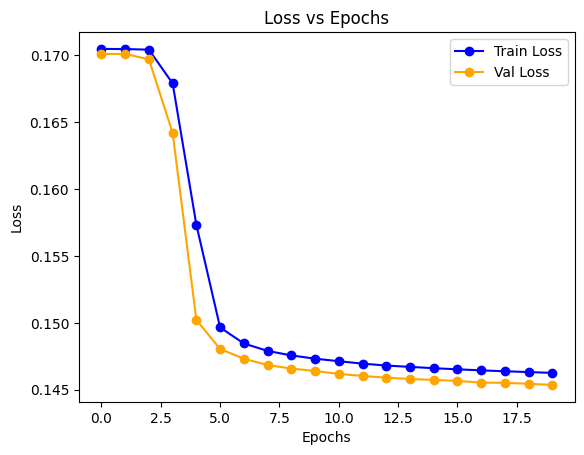

In [42]:
model = CNN_Autoencoder(act_func="relu", lr=1, dropout=0.3, optimiser="sgd").to(device)

# Training the model
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_images, val_images, val_images, epochs=20)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)

# Plotting loss graph
plt.plot(train_loss_arr, color='blue', marker='o', label="Train Loss")
plt.plot(val_loss_arr, color='orange', marker='o', label="Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()
plt.close()

# Latent space feature vectors
latent_space_train_cnn = model.get_encoded_representation(train_images, train_images).reshape(-1, 64)
latent_space_val_cnn = model.get_encoded_representation(val_images, val_images).reshape(-1, 64)
latent_space_test_cnn = model.get_encoded_representation(test_images, test_images).reshape(-1, 64)

## Training MLP Autoencoder

Epoch 1/20 done, Train Loss: 0.0900667791450855
Epoch 2/20 done, Train Loss: 0.05124433209937273
Epoch 3/20 done, Train Loss: 0.04162660284743657
Epoch 4/20 done, Train Loss: 0.03736720671275451
Epoch 5/20 done, Train Loss: 0.034784172017482407
Epoch 6/20 done, Train Loss: 0.03259647256496314
Epoch 7/20 done, Train Loss: 0.03079424415710868
Epoch 8/20 done, Train Loss: 0.029477501945881147
Epoch 9/20 done, Train Loss: 0.028488500141470155
Epoch 10/20 done, Train Loss: 0.02754220249332721
Epoch 11/20 done, Train Loss: 0.026589898253127846
Epoch 12/20 done, Train Loss: 0.0259355628685412
Epoch 13/20 done, Train Loss: 0.025481016985876622
Epoch 14/20 done, Train Loss: 0.025089552204147866
Epoch 15/20 done, Train Loss: 0.024766117564366173
Epoch 16/20 done, Train Loss: 0.024449007704815878
Epoch 17/20 done, Train Loss: 0.024141751139192952
Epoch 18/20 done, Train Loss: 0.02387340131715674
Epoch 19/20 done, Train Loss: 0.023557141574572768
Epoch 20/20 done, Train Loss: 0.023344295841813925


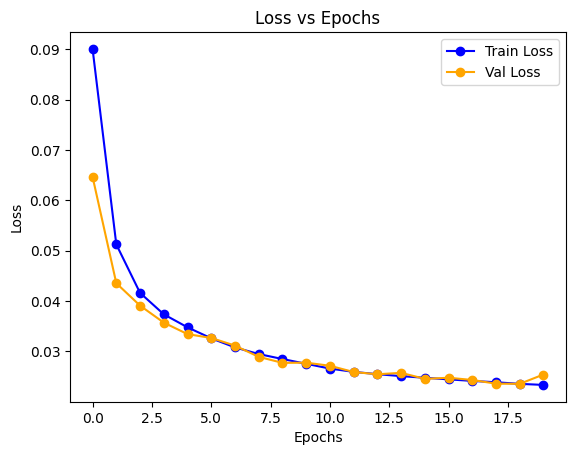

In [27]:
model = MLP_Autoencoder(act_func='relu', lr=1, dropout=0.5, optimiser='sgd').to(device)

# Training the model
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(flattened_train_images, flattened_train_images, flattened_val_images, flattened_val_images, epochs=n_epochs)
torch.save(model.state_dict(), "/content/drive/MyDrive/smai_a4/saved_models/knn/mlp_model.pth")
end_time = time.time()
print("Model Trained in time:", end_time - start_time)

# Plotting loss graph
plt.plot(train_loss_arr, color='blue', marker='o', label="Train Loss")
plt.plot(val_loss_arr, color='orange', marker='o', label="Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()
plt.close()

# Latent space feature vectors
latent_space_train_mlp = model.get_latent_space(flattened_train_images, flattened_train_images)
latent_space_val_mlp = model.get_latent_space(flattened_val_images, flattened_val_images)
latent_space_test_mlp = model.get_latent_space(flattened_test_images, flattened_test_images)

## Training PCA Autoencoder

In [34]:
pca_autoencoder = PCA_Autoencoder()

# Fitting the PCA model
pca_autoencoder = PCA_Autoencoder(op_dim)
start_time = time.time()
pca_autoencoder.fit(train_images)
end_time = time.time()
print("Model fitted in time:", end_time - start_time)

# Latent space feature vectors
latent_space_train_pca = pca_autoencoder.encode(train_images)
latent_space_val_pca = pca_autoencoder.encode(val_images)
latent_space_test_pca = pca_autoencoder.encode(test_images)

Model fitted in time: 1.525846242904663


## KNN Model hyperparameters

In [31]:
k = 50
dist_metric = "manhattan"
headers = [f"Feature {i + 1}" for i in range(op_dim)]
headers.append("label")

## KNN on CNN features

In [43]:
latent_space_train_cnn = np.column_stack((latent_space_train_cnn, train_labels))
latent_space_val_cnn = np.column_stack((latent_space_val_cnn, val_labels))
latent_space_test_cnn = np.column_stack((latent_space_test_cnn, test_labels))

knn_model = KNN(k, dist_metric)
knn_model.load_train_test_val_data(headers, latent_space_train_cnn, latent_space_test_cnn, latent_space_val_cnn)
knn_model.set_predict_var("label")
knn_model.use_for_prediction(headers[:-1])
start_time = time.time()
knn_model.fit()
knn_cnn_predictions = knn_model.predict("test")
metrics = knn_model.get_metrics()
end_time = time.time()
time_diff = end_time - start_time

acc_cnn = metrics['accuracy']

# Printing metrics
print(f"""
k = {k}, Distance Metric = {dist_metric} CNN Autoencoder latent features
Accuracy:   {round(metrics['accuracy'] * 100, 3)}%\n
Time taken: {round(time_diff, 4)} seconds""")


k = 50, Distance Metric = manhattan CNN Autoencoder latent features
Accuracy:   61.2%

Time taken: 427.2163 seconds


## KNN on MLP features

In [44]:
latent_space_train_mlp = np.column_stack((latent_space_train_mlp, train_labels))
latent_space_val_mlp = np.column_stack((latent_space_val_mlp, val_labels))
latent_space_test_mlp = np.column_stack((latent_space_test_mlp, test_labels))

knn_model = KNN(k, dist_metric)
knn_model.load_train_test_val_data(headers, latent_space_train_mlp, latent_space_test_mlp, latent_space_val_mlp)
knn_model.set_predict_var("label")
knn_model.use_for_prediction(headers[:-1])
start_time = time.time()
knn_model.fit()
knn_mlp_predictions = knn_model.predict("test")
metrics = knn_model.get_metrics()
end_time = time.time()
time_diff = end_time - start_time

acc_mlp = metrics['accuracy']

# Printing metrics
print(f"""
k = {k}, Distance Metric = {dist_metric} MLP Autoencoder latent features
Accuracy:   {round(metrics['accuracy'] * 100, 3)}%\n
Time taken: {round(time_diff, 4)} seconds""")


k = 50, Distance Metric = manhattan MLP Autoencoder latent features
Accuracy:   10.4%

Time taken: 405.0947 seconds


## KNN on PCA features

In [53]:
latent_space_train_pca = np.column_stack((latent_space_train_pca, train_labels))
latent_space_val_pca = np.column_stack((latent_space_val_pca, val_labels))
latent_space_test_pca = np.column_stack((latent_space_test_pca, test_labels))

knn_model = KNN(k, dist_metric)
knn_model.load_train_test_val_data(headers, latent_space_train_pca, latent_space_test_pca, latent_space_val_pca)
knn_model.set_predict_var("label")
knn_model.use_for_prediction(headers[:-1])
start_time = time.time()
knn_model.fit()
knn_pca_predictions = knn_model.predict("test")
metrics = knn_model.get_metrics()
end_time = time.time()
time_diff = end_time - start_time

acc_pca = metrics['accuracy']

# Printing metrics
print(f"""
k = {k}, Distance Metric = {dist_metric} PCA Autoencoder latent features
Accuracy:   {round(metrics['accuracy'] * 100, 3)}%\n
Time taken: {round(time_diff, 4)} seconds""")


k = 50, Distance Metric = manhattan PCA Autoencoder latent features
Accuracy:   77.14%

Time taken: 418.9254 seconds


## Plotting accuracy graph of all 3 methods

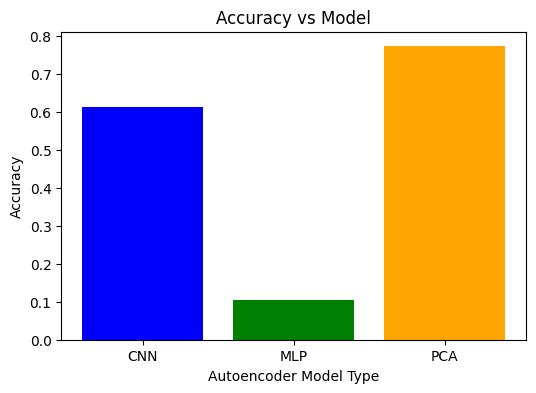

In [54]:
plt.figure(figsize=(6, 4))
plt.bar(["CNN", "MLP", "PCA"], [acc_cnn, acc_mlp, acc_pca], color=['blue', 'green', 'orange'])
plt.xlabel('Autoencoder Model Type')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Model')
plt.show()
plt.close()

## Plotting Confusion Matrix for each of the model

### CNN Model

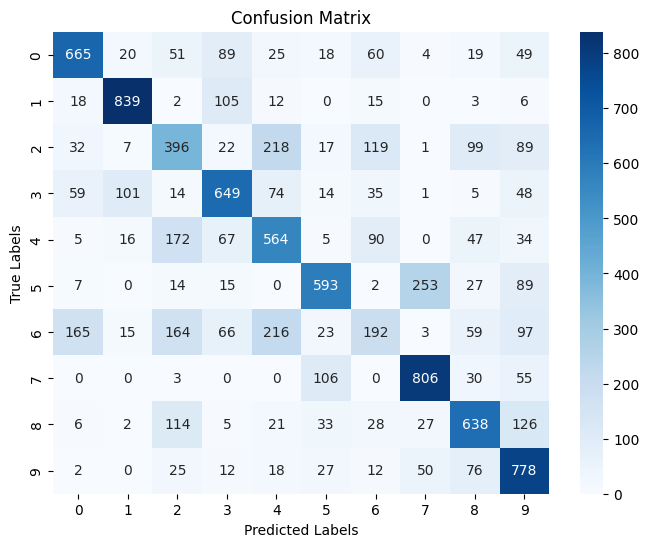

In [ ]:
'''
    ChatGPT generated code.
    Prompt: Give me python code for creating 10x10 confusion matrix using seaborn library.
'''
# ====================================================================
import seaborn as sns

true_labels = np.array(test_labels).astype(int)
predicted_labels = np.array(knn_cnn_predictions).astype(int)
num_classes = 10

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for t, p in zip(true_labels, predicted_labels):
    conf_matrix[t][p] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
plt.close()
# ====================================================================

### MLP Model

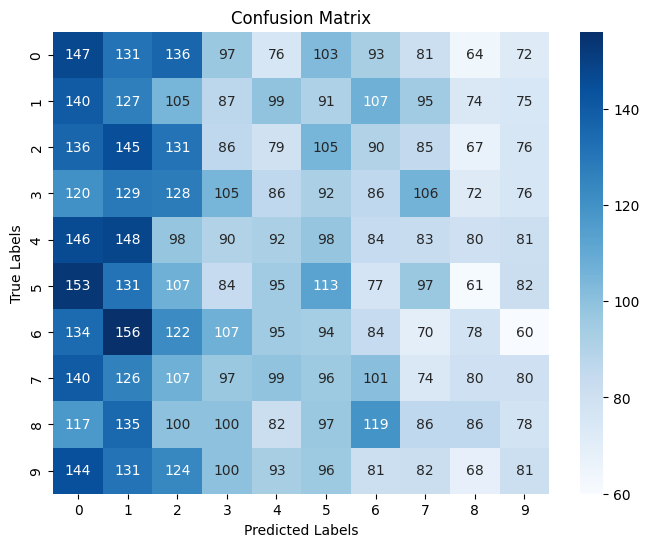

In [50]:
predicted_labels = np.array(knn_mlp_predictions).astype(int)

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for t, p in zip(true_labels, predicted_labels):
    conf_matrix[t, p] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
plt.close()

### PCA Model

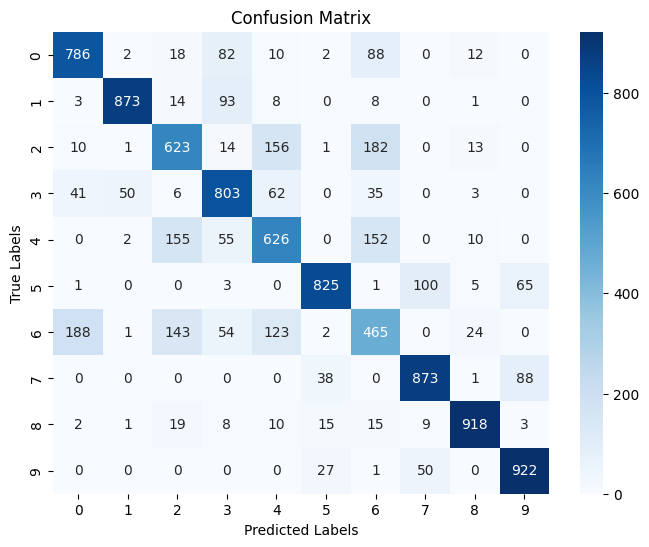

In [51]:
predicted_labels = np.array(knn_pca_predictions).astype(int)

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for t, p in zip(true_labels, predicted_labels):
    conf_matrix[t, p] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
plt.close()

> We can see that all that while MLP model did not give a good latent space feature representation, the other two models are especially good at classifying classes 1, 7 and 9. But there are no classes in my model where all the 3 models perform equally good or best. 